## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you.

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language models (for decoder and encoder)

* or just fine-tunning BART/ELECTRA/... ;)

to improve the translation quality.

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
--2023-12-23 17:32:37--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: 'data.txt'

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.1s    

2023-12-23 17:32:37 (118 MB/s) - 'data.txt' saved [12905334/12905334]



In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torch.utils.data import random_split

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
# from subword_nmt.learn_bpe import learn_bpe
# from subword_nmt.apply_bpe import BPE
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.normalizers import BertNormalizer
from tokenizers.pre_tokenizers import BertPreTokenizer
from tokenizers.processors import TemplateProcessing
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
with open("data.txt") as f:
    data = [l.rstrip().split("\t") for l in f]

print(f"Dataset size {len(data):,}")
print("Sample:")
data[:5]

Dataset size 50,000
Sample:


[['Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.',
  'Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.'],
 ['At Tupirmarka Lodge you will find a 24-hour front desk, room service, and a snack bar.',
  'В числе удобств лоджа Tupirmarka круглосуточная стойка регистрации и снэк-бар. Гости могут воспользоваться услугой доставки еды и напитков в номер.'],
 ['Featuring free WiFi in all areas, Naigao Xiaowo offers accommodation in Shanghai.',
  'Апартаменты Naigao Xiaowo расположены в городе Шанхай. К услугам гостей бесплатный Wi-Fi во всех зонах.'],
 ['Each has a TV and a private bathroom with shower.',
  'В вашем распоряжении также телевизор и собственная ванная комната с душем.'],
 ['Your room comes with air conditioning and satellite TV.',
  'Номер оснащен кондиционером и спутниковым телевидением.']]

In [5]:
data_size = len(data)
train_size = int(0.8 * data_size)
test_size = int(0.15 * data_size)
val_size = data_size - train_size - test_size
train_data, test_data, val_data = random_split(
    data, [train_size, test_size, val_size], generator=torch.Generator().manual_seed(42)
)
print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")
print(f"Val size: {len(val_data)}")

Train size: 40000
Test size: 7500
Val size: 2500


In [6]:
en_text, ru_text = [], []
for en, ru in train_data:
    en_text.append(en)
    ru_text.append(ru)
len(en_text), len(ru_text)

(40000, 40000)

In [7]:
# Baseline solution BLEU score is quite low. Try to achieve at least __21__ BLEU on the test set.
# The checkpoints are:

# * __21__ - minimal score to submit the homework, 30% of points

# * __25__ - good score, 70% of points

# * __27__ - excellent score, 100% of points

### Warning! The code below is deeeeeeeply deprecated and is is provided only as simple guide.
We suggest you to stick to most recent pipelines here, e.g. by Huggingface:
* Example notebook: [link](https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb)
* Converting your own dataset to specific format: [link](https://discuss.huggingface.co/t/correct-way-to-create-a-dataset-from-a-csv-file/15686/15)

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [8]:
tokenizer_en = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer_ru = Tokenizer(BPE(unk_token="[UNK]"))

trainer = BpeTrainer(vocab_size=10000, special_tokens=["[UNK]", "[SOS]", "[EOS]", "[PAD]"])

tokenizer_en.normalizer = BertNormalizer()
tokenizer_ru.normalizer = BertNormalizer()
tokenizer_en.pre_tokenizer = BertPreTokenizer()
tokenizer_ru.pre_tokenizer = BertPreTokenizer()

tokenizer_en.train_from_iterator(en_text, trainer)
tokenizer_ru.train_from_iterator(ru_text, trainer)

tokenizer_en.post_processor = TemplateProcessing(
    single="[SOS] $A [EOS]",
    special_tokens=[
        ("[SOS]", tokenizer_en.token_to_id("[SOS]")),
        ("[EOS]", tokenizer_en.token_to_id("[EOS]")),
    ],
)
tokenizer_ru.post_processor = TemplateProcessing(
    single="[SOS] $A [EOS]",
    special_tokens=[
        ("[SOS]", tokenizer_ru.token_to_id("[SOS]")),
        ("[EOS]", tokenizer_ru.token_to_id("[EOS]")),
    ],
)

In [9]:
out_en = tokenizer_en.encode(en_text[1])
out_ru = tokenizer_ru.encode(ru_text[1])
print(out_en.ids)
print(out_en.tokens)
print(out_ru.ids)
print(out_ru.tokens)
print(f'English vocab size: {tokenizer_en.get_vocab_size()}')
print(f'Russian vocab size: {tokenizer_ru.get_vocab_size()}')

[1, 233, 169, 321, 107, 112, 15, 281, 257, 16, 2]
['[SOS]', 'guests', 'can', 'enjoy', 'the', 'on', '-', 'site', 'bar', '.', '[EOS]']
[1, 69, 1198, 216, 2027, 397, 15, 2]
['[SOS]', 'в', 'здании', 'отеля', 'открыт', 'бар', '.', '[EOS]']
English vocab size: 10000
Russian vocab size: 10000


In [10]:
tokenizer_en.token_to_id("[PAD]"), tokenizer_ru.token_to_id("[PAD]"),

(3, 3)

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
device

device(type='cuda')

In [13]:
def collate_batch(batch):
    src_list, trg_list = [], []
    for src, trg in batch:
        src_encoded = tokenizer_en.encode(src)
        src_list.append(torch.tensor(src_encoded.ids))

        trg_encoded = tokenizer_ru.encode(trg)
        trg_list.append(torch.tensor(trg_encoded.ids))

    src_padded = pad_sequence(src_list, padding_value=tokenizer_en.token_to_id("[PAD]"))
    trg_padded = pad_sequence(trg_list, padding_value=tokenizer_ru.token_to_id("[PAD]"))

    return src_padded, trg_padded

batch_size = 128
train_dataloader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_data, batch_size, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_data, batch_size, shuffle=True, collate_fn=collate_batch)

src_batch, trg_batch = next(iter(train_dataloader))
src_batch.size(), trg_batch.size()

(torch.Size([36, 128]), torch.Size([41, 128]))

In [14]:
print(f'PAD idx EN: {tokenizer_en.token_to_id("[PAD]")}')
print(f'PAD idx RU: {tokenizer_ru.token_to_id("[PAD]")}')
print(f'SOS idx RU: {tokenizer_ru.token_to_id("[SOS]")}')

PAD idx EN: 3
PAD idx RU: 3
SOS idx RU: 1


In [15]:
class Encoder(nn.Module):
    def __init__(self, n_tokens, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.n_tokens = n_tokens
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(n_tokens, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)

    def forward(self, src):
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        _, hidden = self.rnn(embedded)
        return hidden


class Decoder(nn.Module):
    def __init__(self, n_tokens, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.n_tokens = n_tokens
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(n_tokens, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.out = nn.Linear(hid_dim, n_tokens)

    def forward(self, input, hidden):
        input = input.unsqueeze(dim=0)
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)

        output, hidden = self.rnn(embedded, hidden)
        pred = self.out(output.squeeze(dim=0))
        return pred, hidden


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        assert encoder.hid_dim == decoder.hid_dim, "encoder and decoder must have same hidden dim"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "encoder and decoder must have equal number of layers"

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len, batch_size = trg.shape
        preds = []
        hidden = self.encoder(src)

        # First input to the decoder is the <sos> token.
        input = trg[0, :]
        for i in range(1, trg_len):
            pred, hidden = self.decoder(input, hidden)
            preds.append(pred)
            teacher_force = random.random() < teacher_forcing_ratio
            _, top_pred = pred.max(dim=1)
            input = trg[i, :] if teacher_force else top_pred

        return torch.stack(preds)

In [16]:
INPUT_DIM = tokenizer_en.get_vocab_size()
OUTPUT_DIM = tokenizer_ru.get_vocab_size()
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec).to(device)

In [17]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10000, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=10000, bias=True)
  )
)

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 17,606,416 trainable parameters


In [19]:
PAD_IDX = tokenizer_ru.token_to_id("[PAD]")
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [20]:
def train(model, train_dataloader, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()

    epoch_loss = 0
    history = []
    i = 0
    for src, trg in tqdm(train_dataloader):

        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()

        output = model(src, trg)

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]

        loss = criterion(output, trg)

        loss.backward()

        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        i+=1
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()


    return epoch_loss / len(train_dataloader)

In [21]:
def evaluate(model, val_dataloader, criterion):

    model.eval()

    epoch_loss = 0

    history = []

    with torch.no_grad():

        for src, trg in tqdm(val_dataloader):

            src, trg = src.to(device), trg.to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output.view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(val_dataloader)

In [22]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [23]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

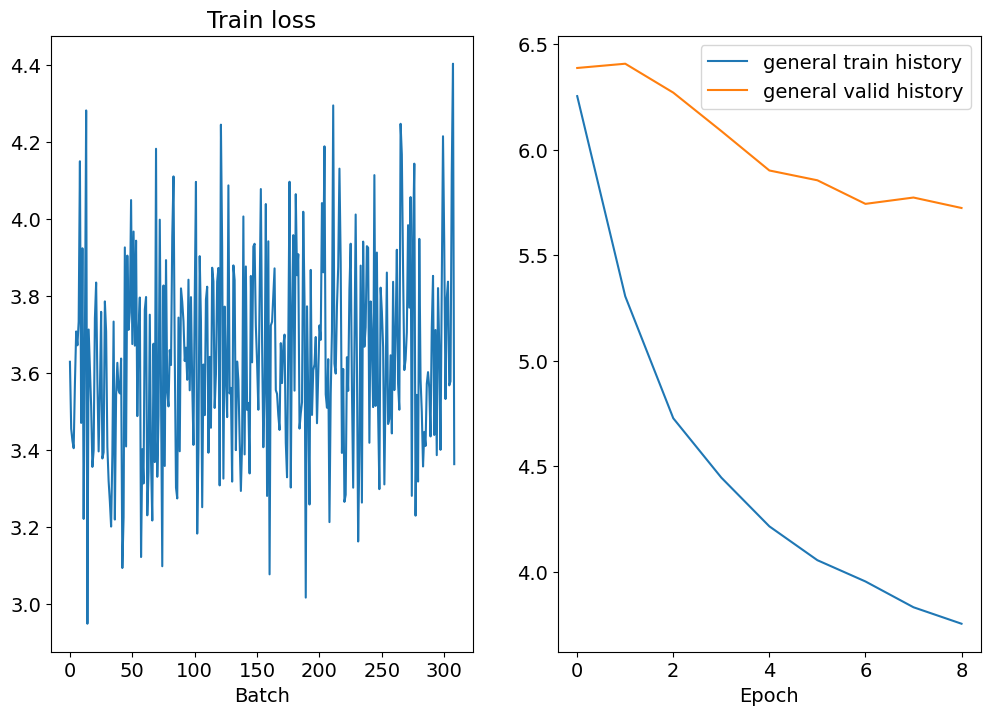

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 10 | Time: 1m 16s
	Train Loss: 3.641 | Train PPL:  38.125
	 Val. Loss: 5.703 |  Val. PPL: 299.641


In [24]:
for epoch in tqdm(range(N_EPOCHS)):

    start_time = time.time()

    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, val_dataloader, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [25]:
def get_text(x, TRG_tokenizer):
    text = TRG_tokenizer.decode(x)
    return text

def generate_translation(src, trg, model, TRG_tokenizer, SRC_tokenizer, n_ex=7):
    model.eval()
    with torch.no_grad():
        src, trg = src.to(device), trg.to(device)

        output = model(src, trg, 0) #turn off teacher forcing
        output = output.argmax(dim=-1).cpu().numpy()

        for i in range(n_ex):
            source = get_text(list(src[:,i].cpu().numpy()), SRC_tokenizer)
            original = get_text(list(trg[:,i].cpu().numpy()), TRG_tokenizer)
            generated = get_text(list(output[:, i]), TRG_tokenizer)

            print('Source: {}'.format(source))
            print('Original: {}'.format(original))
            print('Generated: {}'.format(generated))
            print()


In [26]:
src, trg = next(iter(test_dataloader))
generate_translation(src, trg, model, tokenizer_ru, tokenizer_en)


Source: select rooms offer a fireplace .
Original: в некоторых номерах установлен камин .
Generated: в некоторых номерах имеется гостиная зона . .

Source: the property is 300 metres from the seville cathedral . tri ana bridge - isa bel ii bridge is 800 metres from over land suites catedral , while plaza de armas is 1 . 1 km from the property .
Original: среди близлежащих достопримечательностеи — севиль скии собор в 300 метрах , ору ж еи ная площадь в 1 , 1 км и три ан скии мост , также известныи как мост и за бел лы ii , в 800 метрах .
Generated: апартаменты находятся в 500 метрах от пляжа и в и в 1 , от км от национального музея и в и и в 1 , от км от парка « - - . .

Source: the go ller ’ s restaurant and rustic fran ken stube lounge serve seasonal , franconian cuisine , delicious steak s , and fresh car p .
Original: в ресторане gol ler и лаундже fran ken stube , оформленном в загородном стиле , подают сезонные блюда франкон скои кухни , вкус неи шие стеики и свеже го кар па .
Gene

In [27]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [28]:
references, hypotheses = [], []
model.eval()
with torch.no_grad():
    for src, trg in tqdm(test_dataloader):
        output = model(src.to(device), trg.to(device), teacher_forcing_ratio=0)
        output = output.cpu().numpy().argmax(axis=2)

        for i in range(trg.shape[1]):
            reference = trg[:, i].cpu().numpy()
            reference_tokens = tokenizer_ru.decode(reference)
            references.append(reference_tokens)

            hypothesis = output[:, i]
            hypothesis_tokens = tokenizer_ru.decode(hypothesis)
            hypotheses.append(hypothesis_tokens)

# corpus_bleu works with multiple references
bleu = corpus_bleu([[ref] for ref in references], hypotheses)
print(f"Your model shows test BLEU of {100 * bleu:.1f}")

  0%|          | 0/59 [00:00<?, ?it/s]

Your model shows test BLEU of 41.9


In [29]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for src, trg in tqdm(test_dataloader):

        src, trg = src.to(device), trg.to(device)

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, tokenizer_ru) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, tokenizer_ru) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

  0%|          | 0/59 [00:00<?, ?it/s]

In [30]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

39.01215865495312

In [31]:
import gc
#del transformer
torch.cuda.empty_cache()
gc.collect()

54471

####Transformer

In [32]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout, maxlen=5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen,1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers,
                 emb_size, nhead, src_vocab_size, trg_vocab_size,
                 dim_feedforward, dropout=0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = nn.Transformer(d_model=emb_size, nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout)
        self.generator = nn.Linear(emb_size, trg_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.trg_tok_emb = TokenEmbedding(trg_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self, src, trg,
                src_mask, trg_mask,
                src_padding_mask, trg_padding_mask,
                memory_key_padding_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        trg_emb = self.positional_encoding(self.trg_tok_emb(trg))
        out = self.transformer(src_emb, trg_emb, src_mask, trg_mask, None,
                               src_padding_mask, trg_padding_mask,
                               memory_key_padding_mask)
        return self.generator(out)

    def encode(self, src, src_mask):
        return self.transformer.encoder(self.positional_encoding(self.src_tok_emb(src)), src_mask)

    def decode(self, trg, memory, trg_mask):
        return self.transformer.decoder(self.positional_encoding(self.trg_tok_emb(trg)), memory, trg_mask)

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


In [33]:
torch.manual_seed(42)

SRC_VOCAB_SIZE = tokenizer_en.get_vocab_size()
TGT_VOCAB_SIZE = tokenizer_ru.get_vocab_size()
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 2048
NUM_ENCODER_LAYERS = 6
NUM_DECODER_LAYERS = 6

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [34]:
src, trg = next(iter(train_dataloader))
src.size(), trg.size()

(torch.Size([49, 128]), torch.Size([52, 128]))

In [35]:
def train(model, train_dataloader, optimizer, criterion, clip=None, train_history=None, valid_history=None):
    model.train()

    epoch_loss = 0
    history = []
    i = 0
    for src, trg in tqdm(train_dataloader):

        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()
        
        trg_input = trg[:-1, :]

        src_mask, trg_mask, src_padding_mask, trg_padding_mask = create_mask(src, trg_input)

        output = model(src, trg_input, src_mask,
                       trg_mask, src_padding_mask,
                       trg_padding_mask, src_padding_mask)

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.view(-1, output.shape[-1])
        trg_out = trg[1:, :].view(-1)
        #trg = trg.view(-1)

        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]

        loss = criterion(output, trg_out)

        loss.backward()

        # Let's clip the gradient
        if clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        i+=1
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()


    return epoch_loss / len(train_dataloader)


def evaluate(model, val_dataloader, criterion):

    model.eval()

    epoch_loss = 0

    history = []

    with torch.no_grad():

        for src, trg in tqdm(val_dataloader):

            src, trg = src.to(device), trg.to(device)
            
            trg_input = trg[:-1, :]

            src_mask, trg_mask, src_padding_mask, trg_padding_mask = create_mask(src, trg_input)

            output = model(src, trg_input, src_mask,
                       trg_mask, src_padding_mask,
                       trg_padding_mask, src_padding_mask)

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output.view(-1, output.shape[-1])
            trg_out = trg[1:, :].view(-1)
            #trg = trg.view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg_out)

            epoch_loss += loss.item()

    return epoch_loss / len(val_dataloader)


In [36]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

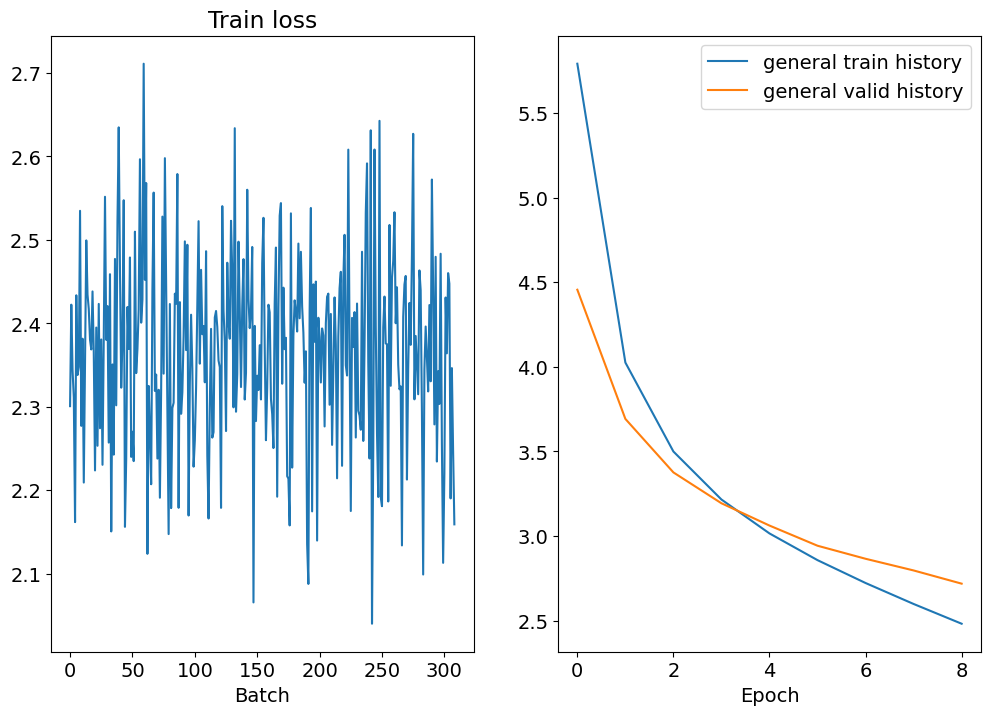

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 10 | Time: 2m 31s
	Train Loss: 2.367 | Train PPL:  10.662
	 Val. Loss: 2.683 |  Val. PPL:  14.627


In [37]:
for epoch in tqdm(range(N_EPOCHS)):

    start_time = time.time()

    train_loss = train(transformer, train_dataloader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(transformer, val_dataloader, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(transformer.state_dict(), 'transformer-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [38]:
EOS_IDX = tokenizer_ru.token_to_id("[EOS]")
SOS_IDX = tokenizer_ru.token_to_id("[SOS]")

def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(device)
    src_mask = src_mask.to(device)
    batch_size = src.size(1)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, batch_size).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        trg_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, trg_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, batch_size).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys

def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    with torch.no_grad():
        src = torch.tensor(tokenizer_en.encode(src_sentence).ids).view(-1, 1)
        num_tokens = src.shape[0]
        src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
        tgt_tokens = greedy_decode(
            model,  src, src_mask, max_len=num_tokens + 5, start_symbol=SOS_IDX).flatten()
        return " ".join(tokenizer_ru.decode(tgt_tokens.cpu().numpy()))

In [39]:
def get_text(x, TRG_tokenizer):
    text = TRG_tokenizer.decode(x)
    return text

def generate_translation(data, model, n_ex=7):
    for i, (src, trg) in enumerate(data):
        if i >= n_ex:
            break
        generated = translate(model, src)

        print('Source: {}'.format(src))
        print('Original: {}'.format(trg))
        print('Generated: {}'.format(generated))
        print()

In [40]:
generate_translation(test_data, transformer)

Source: Use of the kitchen is possible on request.
Original: По запросу гости могут пользоваться кухней.
Generated: п о   з а п р о с у   п р е д о с т а в л я е т с я   ф е н   .

Source: Guests are provided daily breakfast.
Original: Ежедневно для гостей сервируют завтрак.
Generated: е ж е д н е в н о   с е р в и р у е т с я   з а в т р а к   .

Source: The hotel offers free parking.
Original: На территории отеля обустроена бесплатная парковка.
Generated: г о с т я м   п р е д о с т а в л я е т с я   б е с п л а т н а я   п а р к о в к а   .

Source: Apartments Marin Dom Na Sverdlova 2 offers accommodation in Yekaterinburg, 400 metres from Church of All Saints.
Original: Апартаменты «Марьин дом на ул. Свердлова, 2» находятся в Екатеринбурге, в 400 метрах от храма Всех Святых.
Generated: а п а р т а м е н т ы   «   н а   у л и ц е   м а   ю   н а   »   р а с п о л о ж е н ы   в   2   ,   8 0 0   м е т р а х   о т   п л о щ а д и   п ь я ц ц а   -   м а р и я   -   д е   -   с а н   - 

In [41]:
original_text = []
generated_text = []
transformer.eval()
with torch.no_grad():

    for src, trg in tqdm(test_dataloader):

        src, trg = src.to(device), trg.to(device)

        src_mask, trg_mask, src_padding_mask, trg_padding_mask = create_mask(src, trg)

        output = transformer(src, trg, src_mask,
                            trg_mask, src_padding_mask,
                            trg_padding_mask, src_padding_mask)

        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, tokenizer_ru) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, tokenizer_ru) for x in output[1:].detach().cpu().numpy().T])

  0%|          | 0/59 [00:00<?, ?it/s]

In [42]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

18.648659289412063